<a href="https://colab.research.google.com/github/KushagraSinghog/CancerDetection/blob/main/existing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report




In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()


In [ ]:
transform_train = transforms.Compose( [ transforms.RandomResizedCrop(224, scale=(0.9, 1.0)), transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomRotation(15),
                                        transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ] )

transform_test = transforms.Compose( [ transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
transform_valid = transforms.Compose( [ transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
#the normalize tool maps image values from [0,1] to [-1, 1] which is standard for deep learning models
#Compose combines multiple image transformstions sequentially
#ToTensor converts PIL image values (0-255) to pytorch tensors(0-1)
#Normalize normalizes each rgb channel where mean=0.5 and std=0.5 (pixel = (pixel-mean)/std). now it maps the pixel values from [0,1] to [-1,1]


In [ ]:
data_root = "/content/drive/MyDrive/Data"

train_data = datasets.ImageFolder(root=f"{data_root}/train", transform=transform_train)
val_data   = datasets.ImageFolder(root=f"{data_root}/valid", transform=transform_valid)
test_data  = datasets.ImageFolder(root=f"{data_root}/test", transform=transform_test)
#loading the training, test and validation data using imagefolder

In [ ]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
#creating data loaders to load images in batches of 16

print(train_data.classes)
num_classes = len(train_data.classes)

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):                                                        #function to unnormalize and display images
    img = img/2 + 0.5                                                   #unnormalizes the images and converts the tensors from [-1,1] to [0,1]
    npimg = img.numpy()                                                 #converts tensors to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))                          #transpose swaps axises from (C,H,W) to (H,W,C)
    plt.show()

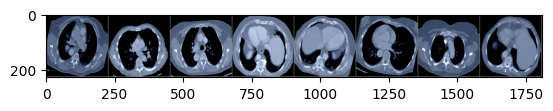

Labels:  ['squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib']


In [ ]:
dataiter = iter(train_loader)                                           #creates an iterator for training images
images, labels = next(dataiter)                                         #gets a batch of images and labels

imshow(torchvision.utils.make_grid(images[:8]))                             #combines multiple images into a single grid (8) and displays them
print('Labels: ', [train_data.classes[i] for i in labels[:8]])                    #prints image labels of the 8 images

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = models.densenet121(weights = "IMAGENET1K_V1")

#for param in model.features.parameters():                                              #freezing entire feature extractor
#    param.requires_grad = False

#for param in model.features.denseblock4. parameters():                                 #unfreezing last denseblock
#    param.requires_grad = True

for param in model.features[-12:].parameters():                                          #unfreezing last dense block and transitional layer
    param.requires_grad = True


num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(nn.Dropout(0.4), nn.Linear(num_ftrs, num_classes))                                 #replacing the classifier

model = model.to(device)

In [ ]:
class_weights = torch.tensor([2.625, 6.176, 5.833, 3.500], dtype=torch.float).to(device)                 #balancing class weights

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2)

In [ ]:
num_epochs = 20
best_loss = float("inf")

for epoch in range(num_epochs):                                                     #training loop
    model.train()
    train_loss = 0.0
    train_total = 0.0
    train_correct = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds==labels).sum().item()

    train_acc = 100*train_correct / train_total
    train_loss /= len(train_loader)



    model.eval()
    val_correct=0.0
    val_total=0.0
    val_loss=0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs=model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100*val_correct/val_total
    val_loss /= len(val_loader)
    scheduler.step(val_loss)



    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")


    print(f"Epoch: [{epoch+1}/{num_epochs}]     training loss: {train_loss:.4f}     training accuracy: {train_acc:.2f}%     validation loss: {val_loss:.4f}     validation accuracy: {val_acc:.2f}%")

Epoch: [1/20]     training loss: 1.0119     training accuracy: 53.67%     validation loss: 0.8822     validation accuracy: 61.11%
Epoch: [2/20]     training loss: 0.5795     training accuracy: 73.25%     validation loss: 0.8050     validation accuracy: 65.28%
Epoch: [3/20]     training loss: 0.3444     training accuracy: 84.67%     validation loss: 0.6811     validation accuracy: 76.39%
Epoch: [4/20]     training loss: 0.2216     training accuracy: 92.82%     validation loss: 0.6088     validation accuracy: 77.78%
Epoch: [5/20]     training loss: 0.1552     training accuracy: 95.11%     validation loss: 0.3503     validation accuracy: 83.33%
Epoch: [6/20]     training loss: 0.1367     training accuracy: 95.60%     validation loss: 0.5769     validation accuracy: 80.56%
Epoch: [7/20]     training loss: 0.1184     training accuracy: 96.25%     validation loss: 0.4017     validation accuracy: 86.11%
Epoch: [8/20]     training loss: 0.0810     training accuracy: 97.23%     validation loss:

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Test accuracy: {accuracy*100:.2f}%")

Test accuracy: 90.79%


                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.86      0.92      0.89       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.89      0.76      0.82        51
                                          normal       1.00      0.98      0.99        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.93      0.93      0.93        90

                                        accuracy                           0.91       315
                                       macro avg       0.92      0.90      0.91       315
                                    weighted avg       0.91      0.91      0.91       315



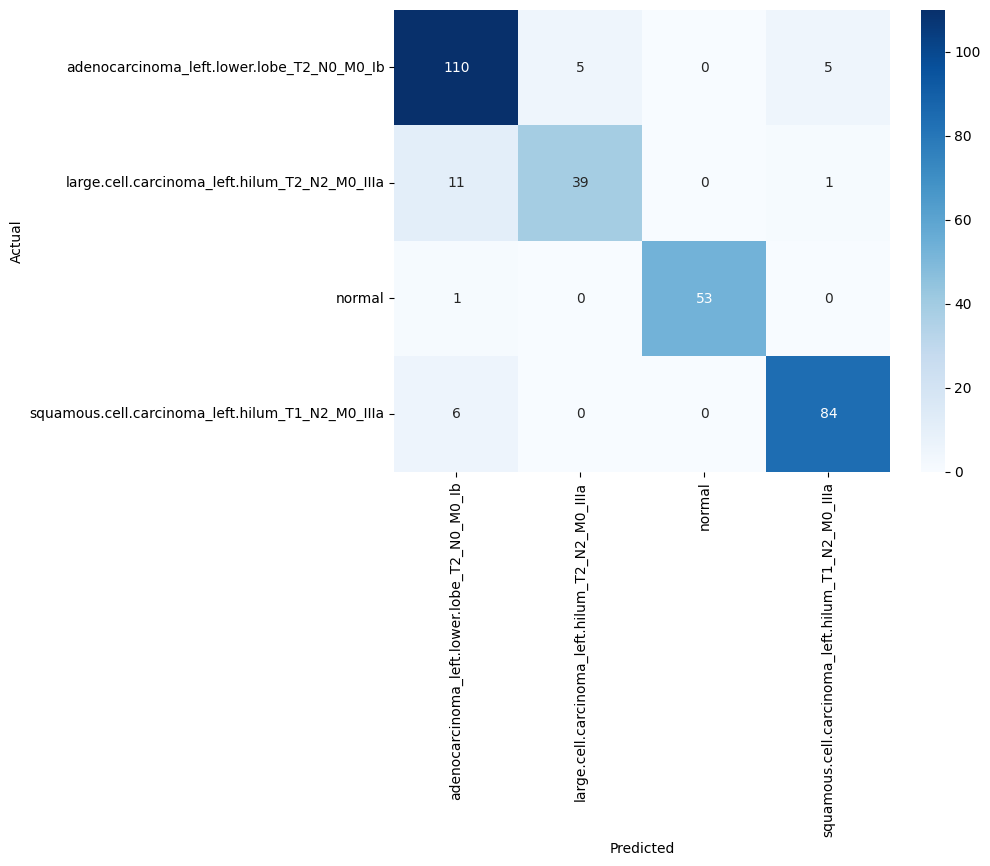

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Classification report
report = classification_report(all_labels, all_preds, target_names=train_data.classes)
print(report)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_data.classes, yticklabels=train_data.classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
import torch
from PIL import Image

class_names = train_data.classes

inference_transform = transforms.Compose([ transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize( [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ] )

In [ ]:
def predict_single_image(model, image_path, device="cpu"):
    """
    Returns:
        {
            'prediction': 'class_name',
            'probabilities': {
                              class1: prob,
                              class2: prob,
                              class3: prob,
                              class4: prob
                            }
        }
    """

    model.eval()
    img = Image.open(image_path).convert("RGB")
    img = inference_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)
        probs = torch.softmax(outputs, dim=1)
        probs = probs.cpu().numpy()[0]

        prob_dict = {class_names[i]: float(probs[i])
                       for i in range(len(class_names))}

        top_class = class_names[np.argmax(probs)]

    return {
        "prediction": top_class,
        "probabilities": prob_dict
      }



def load_best_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = models.densenet121(weights="IMAGENET1K_V1")
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(num_ftrs, num_classes)
    )

    model.load_state_dict(torch.load("best_model.pth", map_location=device))
    model.to(device)
    model.eval()

    return model